# Import Libraries

In [224]:
# Tools
import os
import pandas as pd
import numpy as np
from tqdm import trange
from collections import defaultdict

# Audio file processing
import librosa
import librosa.display

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Dataset Description

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) - [Link](https://zenodo.org/record/1188976#.XTod4S2ZO3U)
  * The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. 
  * Filename identifiers 

    * Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    * Vocal channel (01 = speech, 02 = song).
    * Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    * Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    * Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    * Repetition (01 = 1st repetition, 02 = 2nd repetition).
    * Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Citation

"[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976)" by Livingstone & Russo is licensed under [CC BY-NA-SC 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Load Data

In [145]:
# Load audio file names
data_folder_list = os.listdir('data/')
data_folder_list.remove('.DS_Store')
data = []
for folder in data_folder_list:
    files = os.listdir('data/'+folder)
    for file in files:
        data.append('data/'+folder+'/'+file)

# Create pandas dataframe for all files
emotion_mapping = {1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
gender_mapping = {0:'female',1:'male'}
df = pd.DataFrame({
                   'filename':data,
                   'emotion':[int(x.split('-')[2]) for x in data],
                   'emotion_desc':[emotion_mapping[int(x.split('-')[2])] for x in data],
                   'gender' :[gender_mapping[int(x.split('-')[0][-5:-3])%2] for x in data]
                  
                  })

# Generate Features - Automatic Using librosa.feature

In [146]:
# Specify how many features to create using librosa's automatic feature generation function
num_features = 20

# Function to 
def create_feature_df(sound_list,num_features):
    # Create n number of empty lists to append features to
    empty_lists = [[] for x in range(num_features)]
    
    # Generate features and append to empty lists in empty_lists
    for i in trange(len(sound_list)):
        sound_wave,sampling_rate = librosa.load(sound_list[i],sr=None)
        features = np.mean(librosa.feature.mfcc(y=sound_wave, sr=sampling_rate, n_mfcc=num_features),axis=1)
        for ix,feature in enumerate(features):
            empty_lists[ix].append(feature)
            
    # Create dictionary using feature list and return pandas dataframe
    df = defaultdict()
    for ix,feature in enumerate(empty_lists):
        df['feature_'+str(ix)]=feature    
    return pd.DataFrame(df)

# Create Pandas Dataframe with Data & Features

In [147]:
# Merge df with df_feature
df_features=create_feature_df(df['filename'],num_features)
df_merged = pd.concat([df, df_features], axis=1)
df_merged.head()

100%|██████████| 1440/1440 [00:14<00:00, 97.47it/s] 


,filename,emotion,emotion_desc,gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,data/Actor_16/03-01-05-01-02-01-16.wav,5,angry,female,-563.286011,49.649120,-6.105471,10.458487,-5.491511,-0.331318,...,-8.875373,-1.283287,-4.365212,-6.510464,-3.988040,-2.032984,-6.362742,-3.342318,-6.871845,-2.800561
1,data/Actor_16/03-01-06-01-02-02-16.wav,6,fearful,female,-582.414917,53.827759,-6.217736,7.703194,-1.535679,4.751629,...,-5.080708,0.433190,-7.476514,-10.972321,-2.672167,0.774803,-7.003618,-5.016933,-4.147608,-4.915511
2,data/Actor_16/03-01-06-02-01-02-16.wav,6,fearful,female,-418.499603,39.591286,-25.592112,-2.834799,-5.696198,-2.106591,...,-6.937022,-1.207587,-9.490370,-9.219843,2.695737,6.765974,-1.575575,3.834680,3.455092,4.022371
3,data/Actor_16/03-01-05-02-01-01-16.wav,5,angry,female,-470.210785,48.589828,-8.505497,5.728777,-3.026479,-2.571869,...,-6.192230,0.930403,-5.094486,-6.937154,-0.824439,-1.559173,-6.467396,-2.238223,-6.228177,-4.778912
4,data/Actor_16/03-01-07-01-01-01-16.wav,7,disgust,female,-650.489502,64.394165,0.832174,11.525830,-0.357533,3.591986,...,-5.826626,1.093956,-3.341086,-6.628979,-2.083872,1.503164,-4.994762,-3.326844,-3.126722,-2.403007


# EDA

#### Target Distribution

In [178]:
df_merged['emotion'].value_counts()

8    192
7    192
6    192
5    192
4    192
3    192
2    192
1     96
Name: emotion, dtype: int64

It's pretty evenly distributed between 8 emotions


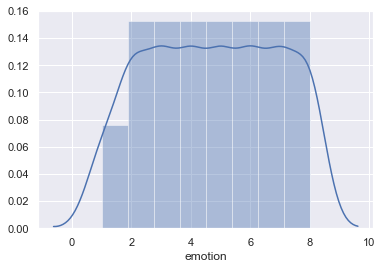

In [184]:
sns.set()
sns.distplot(df_merged['emotion'],bins=8)
print("It's pretty evenly distributed between 8 emotions")

#### Visualize a signal

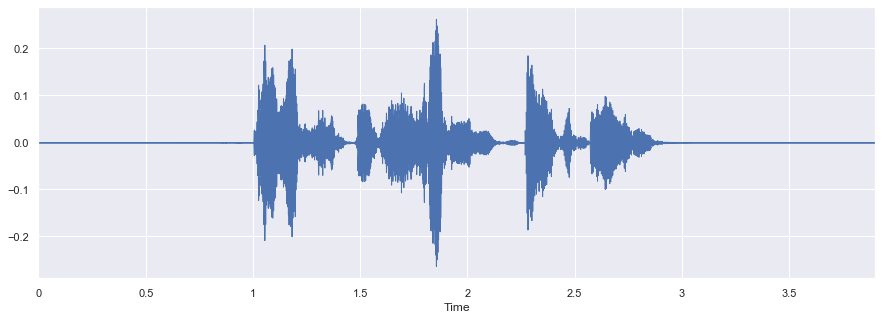

In [185]:
plt.figure(figsize=(15, 5))                    
sound_wave,sampling_rate = librosa.load(df['filename'][0],sr=None)
librosa.display.waveplot(sound_wave,sr=sampling_rate)

# Modeling

#### Train, Validation, Test Split

In [154]:
# Train, Val, Test Split
feature_columns = list(df_merged.columns)[4:]
X_train, X_test, y_train, y_test = train_test_split(df_merged[feature_columns], df_merged['emotion'], test_size=0.2, random_state=209)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=209)

### Baseline Model

#### Standardization of features

In [158]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_va = std.transform(X_val)
X_te = std.transform(X_test)

#### Train Logistic Regression model

In [250]:
clf = LogisticRegression(random_state=209, solver='lbfgs',
                          multi_class='multinomial').fit(X_tr, y_train)

#### View Scores

In [218]:
def various_scores(model,X,y,data_type):
    pred = model.predict(X)
    print(data_type," Data")
    print('######################################################')
    print("Accuracy : {:.2f} %".format(metrics.accuracy_score(y, pred)*100))
    print('______________________________________________________')
    print(metrics.classification_report(pred,y,digits=2,target_names=list(emotion_mapping.values())))
    print('______________________________________________________')
    
    

In [219]:
various_scores(clf,X_tr,y_train,'Train')

Train  Data
######################################################
Accuracy : 48.61 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.20      0.39      0.26        31
        calm       0.61      0.47      0.53       150
       happy       0.42      0.49      0.45        88
         sad       0.41      0.37      0.39       137
       angry       0.73      0.67      0.70       123
     fearful       0.50      0.50      0.50       129
     disgust       0.49      0.51      0.50       104
   surprised       0.39      0.44      0.41       102

    accuracy                           0.49       864
   macro avg       0.47      0.48      0.47       864
weighted avg       0.51      0.49      0.49       864



In [220]:
various_scores(clf,X_va,y_val,'Validation')

Validation  Data
######################################################
Accuracy : 46.18 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.27      0.33      0.30        12
        calm       0.68      0.57      0.62        53
       happy       0.30      0.41      0.35        32
         sad       0.51      0.43      0.47        44
       angry       0.75      0.56      0.64        54
     fearful       0.21      0.22      0.22        27
     disgust       0.35      0.47      0.40        32
   surprised       0.42      0.47      0.44        34

    accuracy                           0.46       288
   macro avg       0.44      0.43      0.43       288
weighted avg       0.50      0.46      0.47       288



In [222]:
various_scores(clf,X_va,y_val,'Val')

Val  Data
######################################################
Accuracy : 46.18 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.27      0.33      0.30        12
        calm       0.68      0.57      0.62        53
       happy       0.30      0.41      0.35        32
         sad       0.51      0.43      0.47        44
       angry       0.75      0.56      0.64        54
     fearful       0.21      0.22      0.22        27
     disgust       0.35      0.47      0.40        32
   surprised       0.42      0.47      0.44        34

    accuracy                           0.46       288
   macro avg       0.44      0.43      0.43       288
weighted avg       0.50      0.46      0.47       288



In [221]:
various_scores(clf,X_te,y_test,'Test')

Test  Data
######################################################
Accuracy : 46.18 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.19      0.36      0.25        11
        calm       0.52      0.44      0.47        39
       happy       0.43      0.56      0.48        36
         sad       0.42      0.28      0.34        46
       angry       0.78      0.62      0.69        50
     fearful       0.46      0.37      0.41        46
     disgust       0.53      0.57      0.55        37
   surprised       0.26      0.43      0.32        23

    accuracy                           0.46       288
   macro avg       0.45      0.45      0.44       288
weighted avg       0.49      0.46      0.47       288



### RandomizedSearchCV

#### Train & Test Split for RandomizedSearchCV

In [229]:
# Train, Val, Test Split
feature_columns = list(df_merged.columns)[4:]
X_train, X_test, y_train, y_test = train_test_split(df_merged[feature_columns], df_merged['emotion'], test_size=0.2, random_state=209)

In [230]:
# Define cross-validation pipelines logistic regression model
lr_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',LogisticRegression())
                        ])

# # print parameters for lasso & ridge cross-validation pipelines
print('Logistic Regression Model Params :\n\n',lr_pipeline.get_params().keys(),'\n')

Logistic Regression Model Params :

 dict_keys(['memory', 'steps', 'verbose', 'polynomial', 'standard', 'model', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'standard__copy', 'standard__with_mean', 'standard__with_std', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start']) 



In [301]:
#Define hyperparameters for GridSearchCV & RandomizedSearchCV
C_vec = np.linspace(0,1000,100)
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'polynomial__degree':[1],
                   'model__solver':['newton-cg', 'sag', 'saga' , 'lbfgs'],
                   'model__C':C_vec,
                   'model__class_weight':['balanced',None],
                   'model__random_state':[209],
                   'model__multi_class':['multinomial']
                   }
lr_rand_grid = RandomizedSearchCV(lr_pipeline,
                             param_distributions=hyperparameters,
                             cv=5,
                             random_state=209,
                             scoring=scoring_list[2],
                             n_iter=30,
                             verbose=0)
lr_rand_grid.fit(X_train,y_train);

/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/matthewlee/anaconda3/envs/metis/lib/python3.7/sit

In [302]:
lr_rand_grid.best_params_

{'polynomial__degree': 1,
 'model__solver': 'lbfgs',
 'model__random_state': 209,
 'model__multi_class': 'multinomial',
 'model__class_weight': None,
 'model__C': 575.7575757575758}

In [303]:
various_scores(lr_rand_grid,X_train,y_train,'Train')

Train  Data
######################################################
Accuracy : 49.39 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.25      0.38      0.30        50
        calm       0.64      0.50      0.56       203
       happy       0.43      0.47      0.45       133
         sad       0.43      0.41      0.42       169
       angry       0.72      0.65      0.68       168
     fearful       0.46      0.47      0.47       153
     disgust       0.47      0.53      0.50       136
   surprised       0.42      0.46      0.44       140

    accuracy                           0.49      1152
   macro avg       0.48      0.48      0.48      1152
weighted avg       0.51      0.49      0.50      1152



In [304]:
various_scores(lr_rand_grid,X_test,y_test,'Test')

Test  Data
######################################################
Accuracy : 50.00 %
______________________________________________________
              precision    recall  f1-score   support

     neutral       0.19      0.44      0.27         9
        calm       0.58      0.46      0.51        41
       happy       0.49      0.57      0.53        40
         sad       0.48      0.34      0.40        44
       angry       0.75      0.67      0.71        45
     fearful       0.54      0.42      0.47        48
     disgust       0.53      0.62      0.57        34
   surprised       0.31      0.44      0.36        27

    accuracy                           0.50       288
   macro avg       0.48      0.50      0.48       288
weighted avg       0.53      0.50      0.51       288

